# Tutorial: Creating TF Records

Last updated: 11/02/2022 by
Cristobal Donoso

In [32]:
cd /home

/home


In [33]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import sys,os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from core.data  import (create_dataset, 
                        pretraining_records)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
name                 = 'alcock'
lightcurves_folder   = f'./data/raw_data/{name}/LCs/' # lightcurves folder
lightcurves_metadata = f'./data/raw_data/{name}/metadata.csv' # metadata file
fold_to_save_records = './data/records_new'

### Metadata frame sample

In [36]:
meta = pd.read_csv(lightcurves_metadata)
print(meta.shape)
meta = meta[meta['Class'] != 'UNK']
meta = meta[meta['Class'] != 'std']
meta = meta[meta['Class'] != 'Dubious']
# meta = meta[meta['N'] >= 20]
meta['Band'] = tf.ones(meta.shape[0])
meta = meta.rename(columns={'objID':'ID', 'Unnamed: 0':'ID', 'Path_R':'Path'})
print(meta.shape)
if 'atlas' in name:
    meta['Path'] = meta['ID'].astype(str)+'.dat'

(21444, 4)
(20894, 4)


In [37]:
change_labels = {'LPV WoodA':'LPV',
                 'LPV WoodB':'LPV', 
                 'LPV WoodC':'LPV', 
                 'LPV WoodD':'LPV'}
meta['Class'] = meta['Class'].replace(change_labels)

In [38]:
meta['Class'].value_counts()

RRab     7397
EC       6824
LPV      3046
RRc      1762
Cep_0    1182
Cep_1     683
Name: Class, dtype: int64

### Lightcurve frame sample

In [39]:
args = {
    'alcock':{},
    'ogle': {'names':['mjd', 'mag', 'errmag'], 'delim_whitespace':True},
    'atlas': {'names':['mjd', 'mag', 'errmag'],'delim_whitespace':False, 'skiprows':1}
}

[INFO] Reading: 55.3247.21.dat


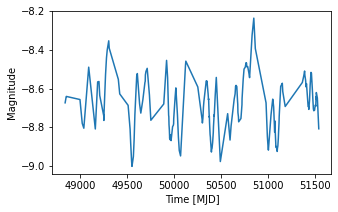

In [40]:
sample = meta.sample()['Path'].values[0].split('/')[-1]
print(f'[INFO] Reading: {sample}')
lc_sample = pd.read_csv(f'{lightcurves_folder}/{sample}', **args[name])
plt.figure(figsize=(5,3))
plt.plot(lc_sample['mjd'], lc_sample['mag'])
plt.xlabel('Time [MJD]')
plt.ylabel('Magnitude')
plt.show()


### Creating training partitions from .csv to .record 

In [47]:
n_folds = 3
samples_per_class_test = 100
samples_per_class = [20, 50, 100, 500]

In [48]:
%%time

for fold_n in range(n_folds): 
    test_meta  = pd.concat([frame.sample(n=samples_per_class_test) for g, frame in meta.groupby('Class')])
    train_meta = meta[~meta['ID'].isin(test_meta['ID'])]
    
    print(test_meta.shape, train_meta.shape)
    print(test_meta['Class'].value_counts())
    
    for nsamples in samples_per_class:  
        if nsamples == 0:
            partial_meta = train_meta
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}'
        else:
            partial_meta = pd.concat([frame.sample(n=nsamples) for c, frame in train_meta.groupby('Class')])
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}_{nsamples}'

        create_dataset(partial_meta, lightcurves_folder, 
                       target, max_lcs_per_record=20000, 
                       n_jobs=7, subsets_frac=(0.8, 0.2), 
                       test_subset=test_meta)

(600, 4) (20294, 4)
Cep_0    100
Cep_1    100
EC       100
LPV      100
RRab     100
RRc      100
Name: Class, dtype: int64
[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 17.86it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.33it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.35it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.11s/it]


(600, 4) (20294, 4)
Cep_0    100
Cep_1    100
EC       100
LPV      100
RRab     100
RRc      100
Name: Class, dtype: int64
[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 13.92it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.55it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.91it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.08s/it]


(600, 4) (20294, 4)
Cep_0    100
Cep_1    100
EC       100
LPV      100
RRab     100
RRc      100
Name: Class, dtype: int64
[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 14.48it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.67it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.96it/s]


[INFO] Using fixed testing subset


100%|██████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.09s/it]

CPU times: user 36.9 s, sys: 1.42 s, total: 38.3 s
Wall time: 43.4 s


## Reading dataset 

In [50]:
fold_to_save_records

'./data/records_new'

In [52]:
for fold_n in range(3):
    for nsamples in samples_per_class:
        if nsamples == 0:
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}'
        else:
            target = f'{fold_to_save_records}/{name}/fold_{fold_n}/{name}_{nsamples}'
        
        n_classes = pd.read_csv(os.path.join(target, 'objects.csv'))
        n_classes = n_classes.shape[0]
        dataset = pretraining_records(os.path.join(target, 'test'),
                                       batch_size=16,
                                       sampling=True,
                                       msk_frac=0., rnd_frac=0., same_frac=0., 
                                       n_classes=n_classes)
        labels = np.concatenate([np.argmax(y, 1) for _, y in dataset], 0)
        unique, counts = np.unique(labels, return_counts=True)
        
        print(unique)
        print(counts)
#         print('-')

[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
[INFO] Processing labels
[0 1 2 3 4 5]
[100 100 100 100 100 100]
